# Objective

This example implements the Compact Convolutional Transformers   models for image classification, demonstrated on the CIFAR-10 dataset:

# Installation of Packages

In [1]:
# !pip install -q tensorflow_datasets
# !pip install datasets
# !pip install keras_cv
# !pip install keras_hub

# Download Dataset from external source

# Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import cifar10
from tensorflow import keras

# from tensorflow.keras.datasets import mnist
# import tensorflow_datasets as tfds
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [4]:
val_split = 0.1
val_indices = int(len(x_train) * val_split)
x_train, y_train = x_train[val_indices:], y_train[val_indices:]

x_val, y_val = x_train[:val_indices], y_train[:val_indices]

# Data Inspection / Visualization

In [5]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_test.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (45000, 32, 32, 3) - y_train shape: (45000, 1)
x_val shape: (5000, 32, 32, 3) - y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [6]:
numRows = x_train.shape[0]
numRows

45000

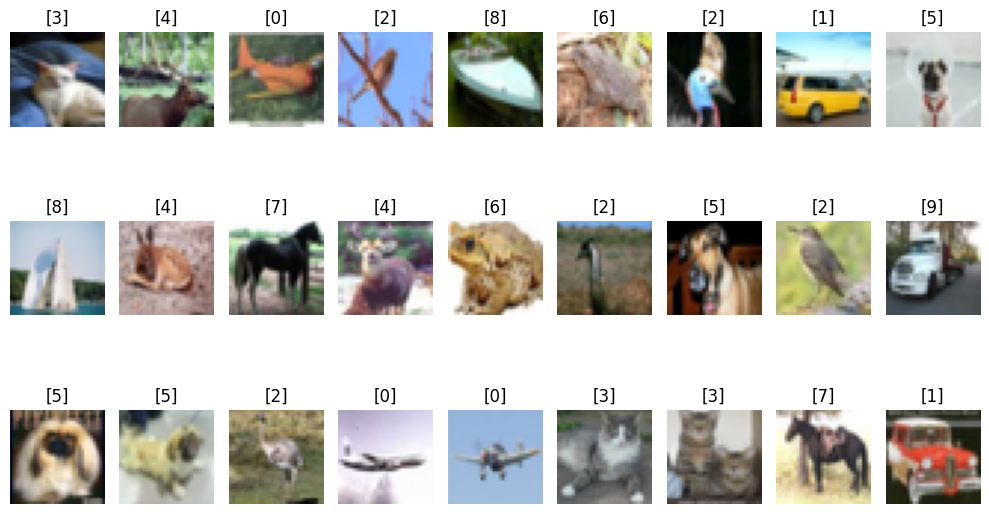

In [7]:
plt.figure(figsize=(10,8))
randomIndex = np.random.randint(0, numRows, 27)
for i in range(27):
    plt.subplot(4, 9, i+1)
    item = x_train[int(randomIndex[i])]
    plt.imshow(item)
    plt.title(y_train[int(randomIndex[i])])
    plt.axis(False)


plt.tight_layout()

# Data Preprocessing

In [8]:
num_classes = len(np.unique(y_train))
input_shape = (32, 32, 3)

num_classes

10

In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 3
image_size = 32
auto = tf.data.AUTOTUNE

In [10]:
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

In [11]:
# y_train = utils.to_categorical(y_train, num_classes)
# y_test = utils.to_categorical(y_test, num_classes)

# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

In [12]:
augmentation_layers = [
    keras.layers.RandomCrop(image_size, image_size),
    keras.layers.RandomFlip("horizontal"),
]


def augment_images(images):
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (augment_images(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)




In [13]:
train_dataset = make_datasets(x_train, y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

In [14]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


# Data Postprocessing

In [15]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

In [16]:
def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


In [17]:
def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x

# Model

In [18]:
def create_cct_model(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [19]:
cct_model = create_cct_model()

In [20]:
#utils.plot_model(model, show_shapes=True)
#model.summary()

# Training

In [21]:
def run_experiment(model):
    
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(
            from_logits=True 
        ),
        metrics=["accuracy"],
    )


    # model.compile(
    #     optimizer=optimizer,
    #     loss=keras.losses.CategoricalCrossentropy(
    #         from_logits=True, label_smoothing=0.1
    #     ),
    #     metrics=[
    #         keras.metrics.CategoricalAccuracy(name="accuracy"),
    #         keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    #     ],
    # )

    checkpoint_filepath = "/tmp/checkpoint.keras"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
     )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    
    evaluation= model.evaluate(test_dataset)

    return history, model, evaluation

In [ ]:
history, model, evaluation = run_experiment(cct_model)

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


162/352 ━━━━━━━━━━━━━━━━━━━━ 19:53 6s/step - accuracy: 0.3897 - loss: 1.6486

# Evaluation

In [ ]:
#  _, accuracy, top_5_accuracy = evaluation
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

 _, accuracy = evaluation
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
def make_plot(metric):
  plt.plot(history.history[metric ])
  plt.plot(history.history['val_'+metric ])
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
  plt.show()

In [ ]:
make_plot('accuracy')
make_plot('loss')

In [ ]:
def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

In [ ]:
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

# Inference

# Deploy

In [ ]:
#model.save("custom_image_classification_model")